In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Set the desired crop size
crop_size = (28, 28)

class RandomCropImage:
    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, image):
        # Get the image dimensions
        width, height = image.size

        # Calculate the top-left corner coordinates of the crop
        top = torch.randint(0, height - self.crop_size[1] + 1, (1,))
        left = torch.randint(0, width - self.crop_size[0] + 1, (1,))

        # Perform the random crop
        image = transforms.functional.crop(image, top.item(), left.item(), self.crop_size[1], self.crop_size[0])
        
        return image

In [3]:
class RandomFlip:
    def __call__(self, image):
        if torch.rand(1) < 0.5:
            return transforms.functional.hflip(image)
        return image

In [4]:
class RandomRotation:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, image):
        angle = torch.randint(-self.degrees, self.degrees, (1,))
        return transforms.functional.rotate(image, angle.item(), resample=Image.BILINEAR)

In [5]:
class RandomColorJitter:
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.color_jitter = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

    def __call__(self, image):
        return self.color_jitter(image)

In [6]:
transform = transforms.Compose([
    RandomFlip(),
    RandomRotation(degrees=15),  # You can adjust the rotation degrees as per your preference
    RandomColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    RandomCropImage(crop_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 2

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                    download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

NameError: name 'images' is not defined

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


model = Net()

In [ ]:
# Create an instance of the model
model = Net()

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    # Wrap the model with DataParallel
    model = nn.DataParallel(model)

# Move the model to the GPU(s) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model to verify DataParallel is used
print(model)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
import numpy as np
losses = []
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 4000 == 3999:    # print every 4000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
    losses.append(running_loss  / 2000)

print('Finished Training')

[1,  4000] loss: 3.879
[1,  8000] loss: 3.443


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

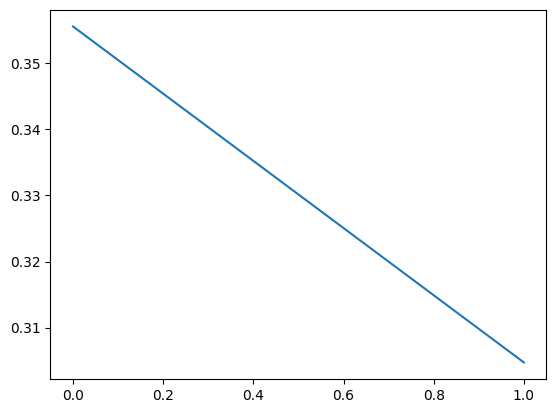

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from numpy import arange
from scipy.optimize import curve_fit

losses = np.array(losses)

plt.plot(losses)
plt.figure()

In [ ]:
# Save model
PATH = './cifar_model.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
# Total accuracy
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 78.9 %
Accuracy for class: car   is 57.7 %
Accuracy for class: bird  is 42.9 %
Accuracy for class: cat   is 36.4 %
Accuracy for class: deer  is 40.5 %
Accuracy for class: dog   is 49.2 %
Accuracy for class: frog  is 66.1 %
Accuracy for class: horse is 60.9 %
Accuracy for class: ship  is 58.5 %
Accuracy for class: truck is 61.4 %
